In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

model = HookedTransformer.from_pretrained(
    'google/gemma-7b',
    tokenizer=tokenizer,
    device='cuda',

    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)

model.set_use_attn_result(True)


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-7b into HookedTransformer


In [3]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval, adversarial_sports_eval_redo
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


train_batch_size = 8
eval_batch_size=32

device = "cuda"
train_loss_type = "sports"


# forget_sport=None
maintain_sport = None
# forget_athletes = 16
# # val_sport = "baseball"

# forget_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": True, "train_test_split": False}
# maintain_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": False, "train_test_split": True}# val_sport = "baseball"
# save_dir = "results/neuron_cb_unlearn_athletes_2"

# forget_sport=None
# forget_athletes = 16
# save_dir = f"results/neuron_cb_{forget_athletes}_athletes_2"
# forget_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": True, "train_test_split": False}
# maintain_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": False, "train_test_split": True}# 
# forget_loss_coef = .5

forget_sport="basketball"
forget_athletes = None
save_dir = f"results/neuron_cb_unlearn_{forget_sport}"
forget_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": True, "train_test_split": True}
maintain_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": False, "train_test_split": True}
forget_loss_coef = .2

os.makedirs(save_dir, exist_ok=True)


sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", **forget_kwargs)

if maintain_sport is None:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
else:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=256, shuffle=True, buffer_size=50000)
train_tasks = {"sports_1mp": (sports_1mp, .2), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}
else:
    maintain_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)
    val_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={val_sport}, is_forget_dataset=True)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sport_eval, "val_sport": val_sport_eval}


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


In [4]:
from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict

import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
print(ap_graph.keys())

# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
print(ct_graph)
model.cuda()

beta = 3
top_p = 5
combine_heads = False

# mask_paths = {
#     "localized_ap": "masks/neuron_cb/gemma_localized_combine_heads=False_beta=3_unlearn_basketball.pt", 
#         "localized_ct": f"masks/neuron_cb/{model_type}_localized_ct_{combine_heads=}_{beta=}_unlearn_{forget_sport}.pt",
#         "random": f"masks/neuron_cb/{model_type}_random_{combine_heads=}_{beta=}_unlearn_{forget_sport}.pt",
#          "manual_interp": "masks/neuron_cb/gemma_manual_interp_combine_heads=False_beta=3_unlearn_basketball.pt",
#          "nonlocalized": "masks/neuron_cb/gemma_nonlocalized_combine_heads=False_beta=3_unlearn_basketball.pt"
#          }

localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "nonlocalized"]
# localization_types = ["manual_interp"]

# masks = {}
# models = {}

all_components = {}

mask_init_funcs = {}

for mask_type in localization_types:
    if mask_type == 'localized_ap':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, combine_heads=combine_heads), n_heads=model.cfg.n_heads, top_p=top_p)

    elif mask_type == 'localized_ct':
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, top_p=top_p, combine_heads=combine_heads)

    elif mask_type == 'manual_interp':
        final_components = []
        for mlp_layer in range(2, 8):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'random':
        final_components, final_attn_heads = get_random_components(n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads, top_p=top_p, combine_subcomponents=False)

    elif mask_type == 'nonlocalized':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, combine_heads=combine_heads), n_heads=model.cfg.n_heads, top_p=100)
        assert (torch.tensor([len(x) for x in final_attn_heads.values()]) == model.cfg.n_heads).all()

    all_components[mask_type] = (final_components, final_attn_heads)


def init_mask_func(mask_type):
    def get_mask_fn(model):
        mask = NeuronLevelMask(model, components=all_components[mask_type][0], component_heads=all_components[mask_type][1])
        return mask
    return get_mask_fn
for mask_type in localization_types:
    mask_init_funcs[mask_type] = init_mask_func(mask_type)

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

## Train Masks

In [5]:
from collections import defaultdict


combine_heads = False
top_p = 5
# learning_rate = 1e-2
# n_epochs = 100
# grad_accum_steps = 16
learning_rate = 5e-2
n_epochs = 50
grad_accum_steps = 8
# max_gpu_batch_size=8
beta = 3
clip_grad = 1

evaluate_every = 5
n_eval_iters = 5
deep_evaluate_every = 5
do_adversarial_evals = False
do_side_effects_evals = True

model.reset_hooks()
model.cuda()
use_wandb = True

import wandb

for mask_type in mask_init_funcs:
    if use_wandb:
        wandb.init(project="circuit_breaking", name=f"neuron_cb_unlearn_athletes_{model_type}_{mask_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}")
        wandb.config.update({"model_type": model_type, "mask_type": mask_type, "combine_heads": combine_heads, "beta": beta, "forget_sport": forget_sport, "forget_athletes": forget_athletes, "forget_loss_coef": forget_loss_coef, "top_p": top_p, "learning_rate": learning_rate, "n_epochs": n_epochs, "grad_accum_steps": grad_accum_steps, "clip_grad": clip_grad})

# for mask_type in ["nonlocalized"]:
    mask = mask_init_funcs[mask_type](model)
    mask.cuda()

    all_train_losses = defaultdict(list)
    all_test_losses = defaultdict(list)
    adversarial_evals = []
    side_effect_evals = []

    # Initialize optimizer

    optimizer = torch.optim.AdamW(mask.parameters(), lr=learning_rate, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    # Cycle dataloaders
    # Train a sparse mask
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        # Sample batches
        # Reset grad
        optimizer.zero_grad()
        # Compute normal loss over retain
        for task_name, (task, task_weight) in train_tasks.items():
            task_loss = 0
            for i in range(grad_accum_steps):
                loss = task.get_train_loss(model) / grad_accum_steps
                task_loss += loss.item()
                loss *= task_weight
                loss.backward()
            all_train_losses[task_name].append(task_loss)
            if use_wandb:
                wandb.log({f"{task_name}_train_loss": task_loss}, step=epoch)
            
        # Add sparsity loss and backprop
        loss = beta * mask.regularization_loss()
        loss.backward()
        all_train_losses["reg"].append(loss.item())
        # Step and log
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(mask.parameters(), clip_grad)
        # zero_nan_grads(mask)
        optimizer.step()
        mask.on_step_end()
        scheduler.step()

        if epoch % evaluate_every == 0 or epoch == n_epochs - 1:
            for task_name, task in eval_tasks.items():
                task_loss = 0
                task_accuracy = 0
                for i in range(n_eval_iters):
                    task_loss += task.get_test_loss(model).item()
                    task_accuracy += task.get_test_accuracy(model)
                all_test_losses[task_name].append(task_loss / n_eval_iters)
                if use_wandb:
                    wandb.log({f"{task_name}_test_loss": task_loss / n_eval_iters}, step=epoch)
                    wandb.log({f"{task_name}_test_accuracy": task_accuracy / n_eval_iters}, step=epoch)
        if epoch % deep_evaluate_every == 0 or epoch == n_epochs - 1:
            if do_adversarial_evals:
                print("Running adversarial evals")
                adversarial_evals.append(adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
            forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
            maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
            continuous=True, include_evals=["Normal", "MC"]))
            if do_side_effects_evals:
                print("Running side effects evals")
                side_effect_evals.append(run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"]))
                if use_wandb:
                    wandb.log(side_effect_evals[-1]["General"], step=epoch)

    
    os.makedirs(f"{save_dir}/masks", exist_ok=True)
    torch.save(mask.state_dict(), f"{save_dir}/masks/{model_type}_{mask_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt")

    with open(f"{save_dir}/masks/{model_type}_{mask_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", "wb") as f:
        pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)
    
    mask.cpu()
    model.reset_hooks()
    del mask

    if use_wandb:
        wandb.finish()

Moving model to device:  cuda


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


  0%|          | 0/50 [00:00<?, ?it/s]

Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MMLU,▆▁▄▄▄█▇█▇▇█
forget_sport_test_accuracy,█▁▁▁▁▂▁▁▁▁▁
forget_sport_test_loss,▁██▆▅▄▅▄▅▄▄
induction_test_accuracy,███▁▅▃▅▆▅██
induction_test_loss,▂█▂▂▃▁▁▁▁▂▂
maintain_sport_test_accuracy,▁▆██████▇▇█
maintain_sport_test_loss,█▁▁▁▁▁▁▁▁▁▁
maintain_sports_train_loss,▇█▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
pile_test_accuracy,▁▁▁▁▁▁▁▁▁▁▁
pile_test_loss,▆▁▃▄▆▄▄█▆▆▃
pile_train_loss,▃▃▄▆▅▂▂▆▂▇▅▂▂▂▃▄▆▃▆▇▃▁▃█▅▃▄▆▅▁▂▆▅▃▄▅▃▂▁▃


  0%|          | 0/50 [00:00<?, ?it/s]

Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MMLU,▃▆██▄▃▁█▁▄▃
forget_sport_test_accuracy,█▁▁▁▁▁▁▁▁▁▁
forget_sport_test_loss,▁▇█▇▇██████
induction_test_accuracy,▁██████▁███
induction_test_loss,▂█▆▄▃▁▄▂▄▄▂
maintain_sport_test_accuracy,▁▇▇█▇▇▇▇▇▆▅
maintain_sport_test_loss,█▁▁▁▁▁▁▁▁▁▁
maintain_sports_train_loss,█▅▅▄▆▁▄▁▁▁▁▁▁▂▁▁▁▇▂▁▁▁▁▁▁▁▁▁▂▁▁▁▃▁▂▁▅▁▁▁
pile_test_accuracy,▁▁▁▁▁▁▁▁▁▁▁
pile_test_loss,▇▇▁▁▂▁▄▅▅█▄
pile_train_loss,▅▅▅▆▇▇▃▇▅▅▆▅▇▅▅█▅▆▆▆▁▇▄▄▂▆▃▅▆▇▅▂▄▅▄▇▅█▄▅


  0%|          | 0/50 [00:00<?, ?it/s]

Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MMLU,▆▅█▅▅▆▁▅▃▁▁
forget_sport_test_accuracy,█▅▂▁▁▁▁▁▁▁▁
forget_sport_test_loss,▁▃▆▇█▇▇▇▇▇▇
induction_test_accuracy,▁▄██▄███▄▄█
induction_test_loss,█▃▂▆▁▃▄▃▆▂▅
maintain_sport_test_accuracy,█▁▆██▇▇█▇█▇
maintain_sport_test_loss,▇█▃▂▁▁▁▁▁▁▁
maintain_sports_train_loss,▆█▅▇▅█▄▃▃▂▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂
pile_test_accuracy,▁▁▁▁▁▁▁▁▁▁▁
pile_test_loss,█▃▄▂█▇▆▃▁▂█
pile_train_loss,▃▄▄▃▆▃█▄▂▇▆▄▄▄▇▆▅▄▅▇▅▄▃▄▇▄▃▅▁▃▄▅▃▇▅▆▄▇▂▅


  0%|          | 0/50 [00:00<?, ?it/s]

Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MMLU,███▆▃▃▆█▆▁▆
forget_sport_test_accuracy,█▆▂▁▁▁▁▁▁▁▁
forget_sport_test_loss,▁▁▄▇▇▇▇▇███
induction_test_accuracy,████▁█▁██▁█
induction_test_loss,▇▂▅▇▅▆▇▅▁█▃
maintain_sport_test_accuracy,▇▁▄▅█▇▆▇▇▇█
maintain_sport_test_loss,██▄▃▂▂▂▂▁▁▁
maintain_sports_train_loss,▆▅█▆▆▆▅▄▄▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃
pile_test_accuracy,▁▁▁▁▁▁▁▁▁▁▁
pile_test_loss,▇▄▁▅▆▅▂█▅▃▂
pile_train_loss,▆▆▄▄▂▁▂▅▃▆▃▅▃▅▇▅▅▄█▅▄▅▃▅▂▃▂▅▄▄▆▅▅▆▄▂▃▂▄▄


  0%|          | 0/50 [00:00<?, ?it/s]

Running side effects evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MMLU,█▇▁▇▇▇█▇█▆▆
forget_sport_test_accuracy,█▁▁▁▂▁▁▁▂▁▁
forget_sport_test_loss,▁█▄▄▄▄▄▅▅▅▅
induction_test_accuracy,▇▁█▄▅▇▇▄▇▇▆
induction_test_loss,▁▅▅█▅▄▆▆▃▄▆
maintain_sport_test_accuracy,▅▂▁▄▆▅▆█▇██
maintain_sport_test_loss,█▅▂▂▁▁▁▁▁▁▁
maintain_sports_train_loss,▄▅▁▁▁▇▄█▂▁▃▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pile_test_accuracy,▁▁▁▁▁▁▁▁▁▁▁
pile_test_loss,█▅▆▄▃▇▁▁▂▂▃
pile_train_loss,▄█▇▄▆▄█▅▇▅▅▆▅▅▆▅▄▄▂▆▆▁▆▃▅▆▄▅▃▆▅▄▂▄▅▇▅▆▅▄


## Analyze Mask

In [5]:
from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict

import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
print(ap_graph.keys())

# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
print(ct_graph)
model.cuda()

beta = 3
top_p = 5
combine_heads = False
forget_athletes=None
forget_sport = "basketball"

# save_dir = f"results/neuron_cb_{forget_athletes}_athletes_2"
save_dir = f"results/neuron_cb_unlearn_{forget_sport}"

mask_paths = {
    "localized_ap": f"{save_dir}/masks/gemma_localized_ap_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt", 
        "localized_ct": f"{save_dir}/masks/{model_type}_localized_ct_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt",
        "random": f"{save_dir}/masks/{model_type}_random_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt",
         "manual_interp": f"{save_dir}/masks/gemma_manual_interp_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt",
         "nonlocalized": f"{save_dir}/masks/gemma_nonlocalized_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt"
         }

# masks = {}
# models = {}

all_components = {}
for mask_type, mask_path in mask_paths.items():
    if mask_type == 'localized_ap':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, combine_heads=combine_heads), n_heads=model.cfg.n_heads, top_p=top_p)

    elif mask_type == 'localized_ct':
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, top_p=top_p, combine_heads=combine_heads)

    elif mask_type == 'manual_interp':
        final_components = []
        for mlp_layer in range(2, 8):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

    elif mask_type == 'random':
        from circuit_breaking.src.masks import convert_param_name
        state_dict = torch.load(mask_path)
        final_components = []
        final_attn_heads = defaultdict(list)
        for key in state_dict.keys():
            if "masks.blocks" not in key:
                continue
            component_name = convert_param_name(key, inverse=True)
            # cut off "masks."
            component_name = component_name[6:]
            final_components.append(component_name)
            if "attn" in component_name:
                final_attn_heads[component_name] = list(range(model.cfg.n_heads))

    elif mask_type == 'nonlocalized':
        final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, n_heads=model.cfg.n_heads, n_layers=model.cfg.n_layers, combine_heads=combine_heads), n_heads=model.cfg.n_heads, top_p=100)
        assert (torch.tensor([len(x) for x in final_attn_heads.values()]) == model.cfg.n_heads).all()

    all_components[mask_type] = (final_components, final_attn_heads)


def init_and_load_mask_func(mask_path, mask_type):
    def get_mask_fn(model):
        mask = NeuronLevelMask(model, components=all_components[mask_type][0], component_heads=all_components[mask_type][1])
        mask.load_state_dict(torch.load(mask_path))
        return mask
    return get_mask_fn

mask_init_and_load_funcs = {}
for mask_type in mask_paths.keys():
    mask_init_and_load_funcs[mask_type] = init_and_load_mask_func(mask_paths[mask_type], mask_type)

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

### Visualize Mask Values

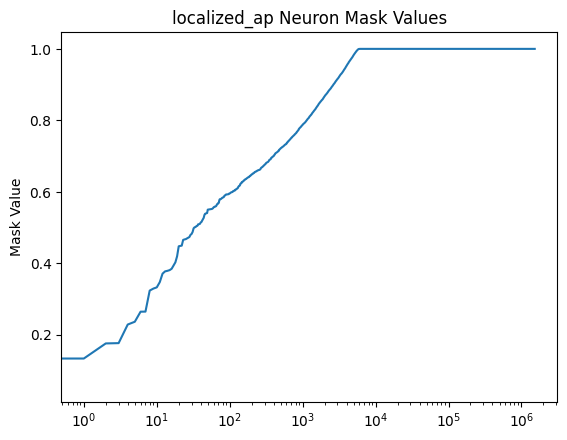

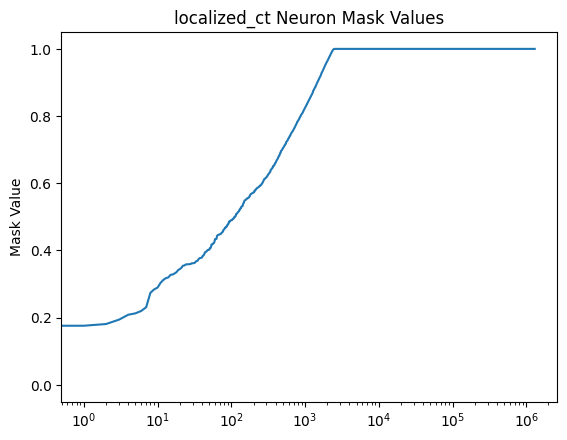

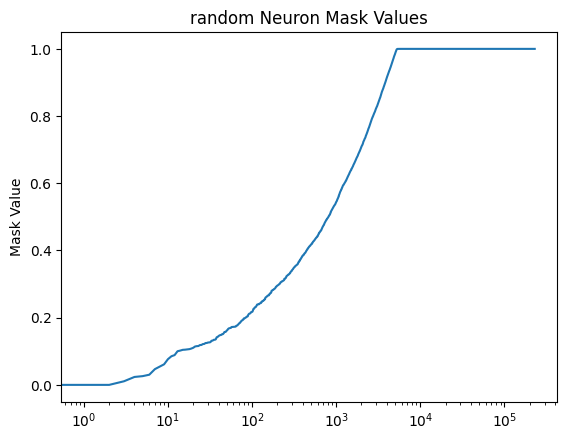

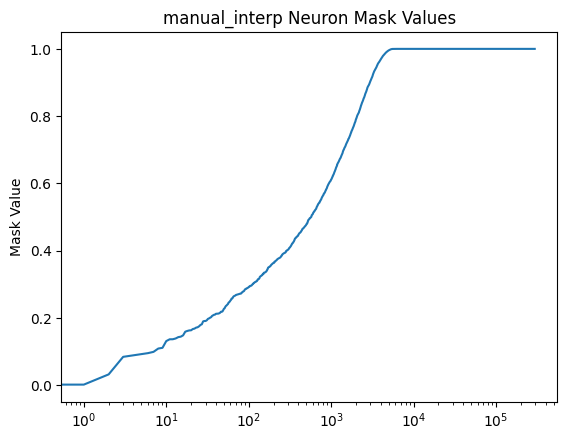

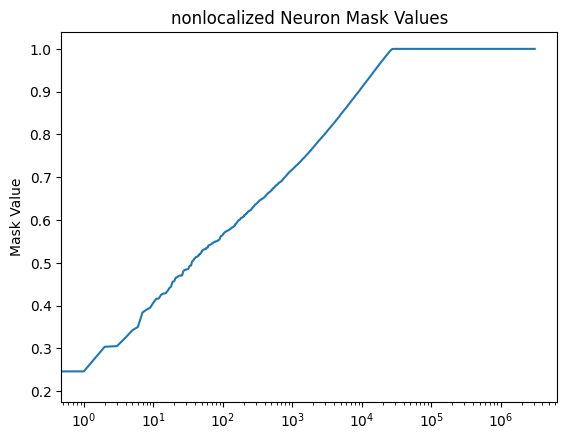

In [6]:
# Visualize the neuron coefficients
# for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
# for title, mask in masks.items():
for title in mask_init_and_load_funcs:
    mask = mask_init_and_load_funcs[title](model)
    mask.cuda()
    all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
    sorted_values = all_values.sort().values
    plt.semilogx(sorted_values)
    plt.title(f"{title} Neuron Mask Values")
    plt.ylabel("Mask Value")
    plt.show()

    mask.cpu()
    model.reset_hooks()
    del mask
# all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
# sorted = all_values.sort().values
# plt.semilogx(sorted)
# plt.title("Neuron Mask Values")
# plt.ylabel("Mask Value")
# plt.show()


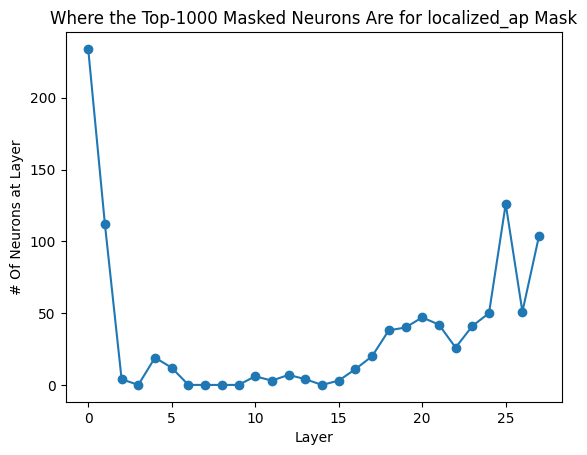

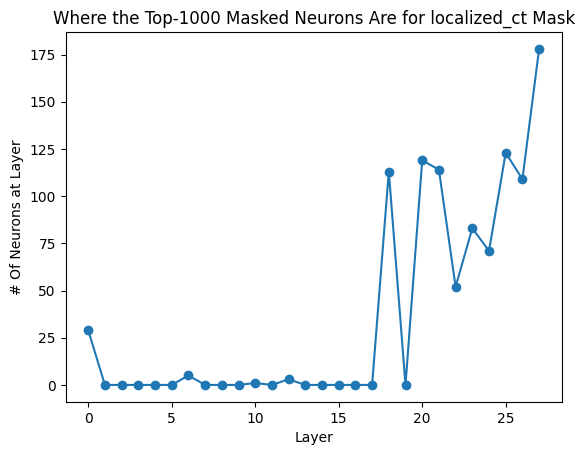

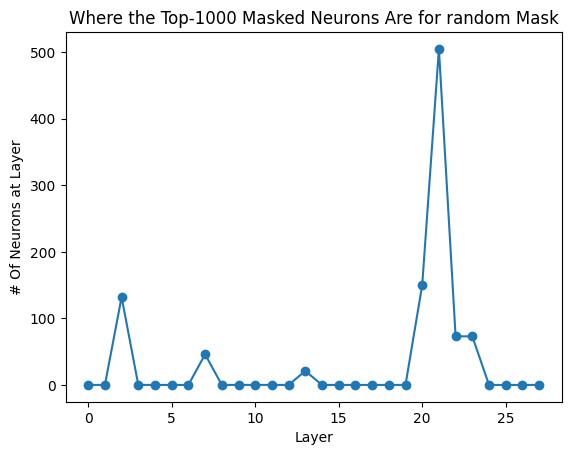

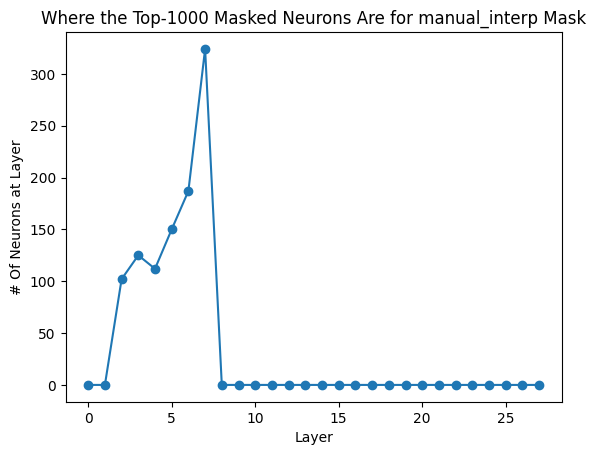

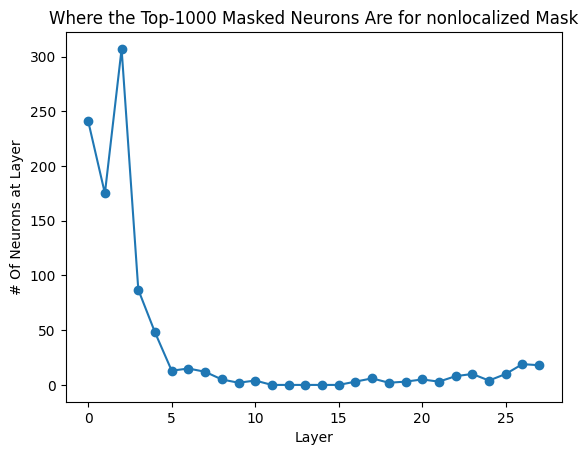

In [7]:
# Visualize the neuron coefficients
top_k = 1000
# for title, mask in [("Localized", localized_mask), ("Non-Localized", nonlocalized_mask)]:
# for title, mask in masks.items():
for title in mask_init_and_load_funcs:
    mask = mask_init_and_load_funcs[title](model)
    mask.undiscretize()
    mask.discretize_topk(top_k)
    all_values = {layer: 0 for layer in range(model.cfg.n_layers)}
    for component in mask.mask_masks:
        layer = int(component.split("&")[1])
        all_values[layer] += (mask.mask_masks[component].data == 1).sum().item()

    # all_values = [(m.data == 1).sum().item() for m in mask.mask_masks.values()]
    plt.plot(all_values.values(), marker='o')
    plt.title(f"Where the Top-{top_k} Masked Neurons Are for {title} Mask")
    plt.ylabel("# Of Neurons at Layer")
    plt.xlabel("Layer")
    plt.show()

    mask.cpu()
    model.reset_hooks()
    del mask


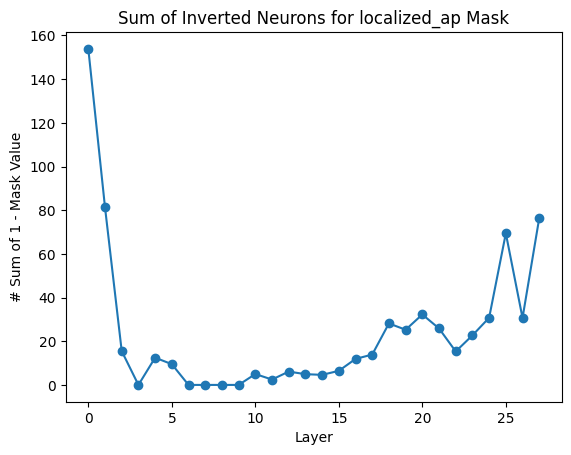

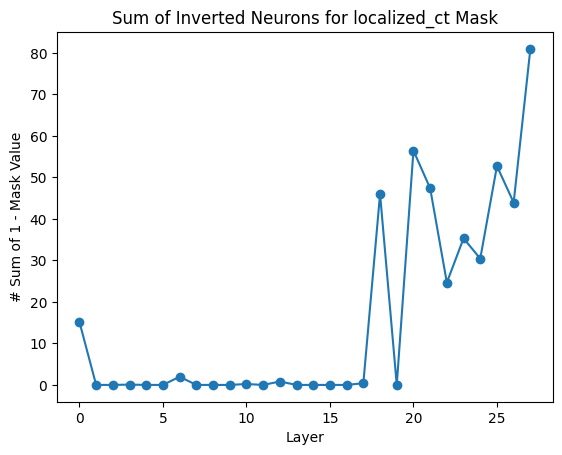

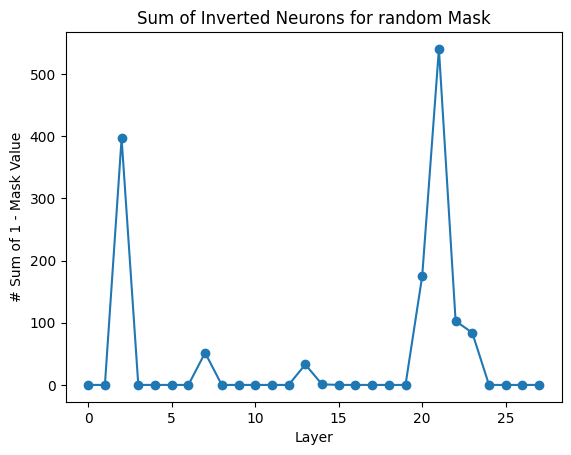

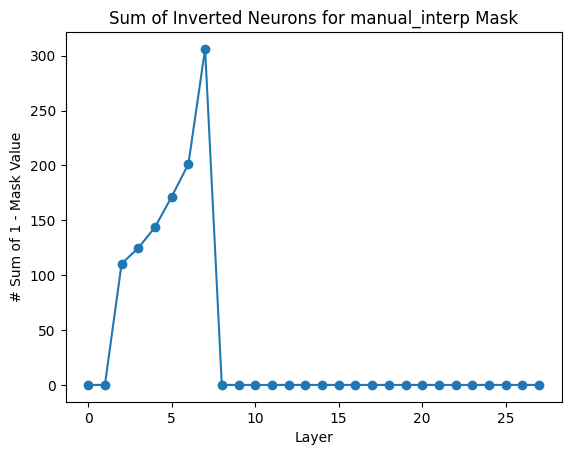

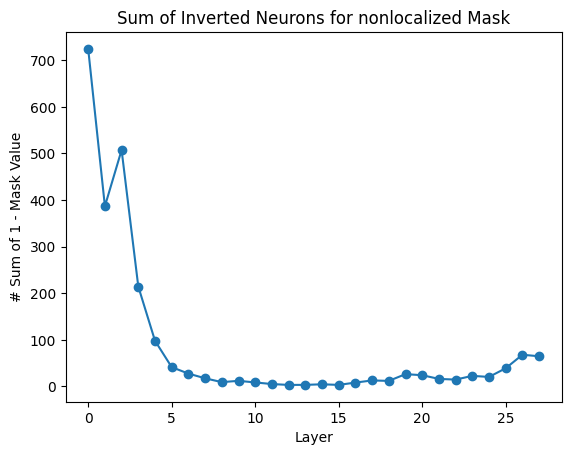

In [8]:
# plot sum of inverted mask values of layer

for title in mask_init_and_load_funcs:
    mask = mask_init_and_load_funcs[title](model)
    layer_sums = {l: 0 for l in range(model.cfg.n_layers)}
    for component in mask.mask_masks:
        layer = int(component.split("&")[1])
        layer_sums[layer] += (1-mask.masks[component].data).sum().item()

    # all_values = [(m.data == 1).sum().item() for m in mask.mask_masks.values()]
    plt.plot(layer_sums.values(), marker='o')
    plt.title(f"Sum of Inverted Neurons for {title} Mask")
    plt.ylabel("# Sum of 1 - Mask Value")
    plt.xlabel("Layer")
    plt.show()

    mask.cpu()
    model.reset_hooks()
    del mask


### Run Evals

In [9]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated() // 1024 // 1024 // 1024


19

In [10]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo


model.reset_hooks()
for title in mask_init_and_load_funcs:
    print(f"Final evals for {title} Mask")
    # model = models[title]
    mask = mask_init_and_load_funcs[title](model)
    print(f"Loaded mask {title} into model")
    # model.cuda()
    mask.cuda()
    mask.undiscretize()

    # final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=True)
    # print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
    # final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=False, continuous=True)
    # print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")
    final_adversarial_eval = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                                                          forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                                                          maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                                                          continuous=True)
    print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
    final_adversarial_eval = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                                                        forget_task_init_kwargs={"use_system_prompt":False, "use_icl":False}|forget_kwargs, 
                                                        maintain_task_init_kwargs={"use_system_prompt":False, "use_icl":False}|maintain_kwargs, 
                                                        continuous=True)
    print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")

    final_side_effects = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "General", "Cross Entropy"], verbose=False)
    print(final_side_effects)

    mask.cpu()
    model.reset_hooks()
    del mask

Final evals for localized_ap Mask
Loaded mask localized_ap into model


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


System Prompt: adversarial evals are {'Normal': {'forget': 0.1185546875, 'maintain': 0.9976562499999999}, 'MC': {'forget': 0.6492187500000001, 'maintain': 0.96484375}, 'Capitalized': {'forget': 0.1330078125, 'maintain': 0.996875}, 'Dashed': {'forget': 0.3150897979736328, 'maintain': 0.7479954719543458}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.024707031249999997, 'maintain': 0.9976562500000001}, 'MC': {'forget': 0.50625, 'maintain': 0.9007812499999999}, 'Capitalized': {'forget': 0.032214355468750004, 'maintain': 0.99765625}, 'Dashed': {'forget': 0.2864651709794998, 'maintain': 0.9212722301483154}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.68, 'tennis': 0.9}, 'General': {'MMLU': 0.67}, 'Cross Entropy': {'Pile': 2.3, 'OWT': 2.515625}}
Final evals for localized_ct Mask
Loaded mask localized_ct into model
System Prompt: adversarial evals are {'Normal': {'forget': 0.20156249999999998, 'maintain': 0.99921875}, 'MC': {'forget': 0.853125, 'maintain': 0.96015625}, 'Capitalized': {'forget': 0.2568359375, 'maintain': 0.99609375}, 'Dashed': {'forget': 0.5193832039833068, 'maintain': 0.7727154970169068}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.018115234374999997, 'maintain': 0.9984375000000001}, 'MC': {'forget': 0.6234375, 'maintain': 0.86796875}, 'Capitalized': {'forget': 0.046533203125000006, 'maintain': 0.9945312500000001}, 'Dashed': {'forget': 0.4338579535484314, 'maintain': 0.940483570098877}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.76, 'tennis': 0.98}, 'General': {'MMLU': 0.6399999999999999}, 'Cross Entropy': {'Pile': 2.33125, 'OWT': 2.525}}
Final evals for random Mask
Loaded mask random into model
System Prompt: adversarial evals are {'Normal': {'forget': 0.329296875, 'maintain': 0.9984374999999999}, 'MC': {'forget': 0.8406250000000001, 'maintain': 0.9624999999999999}, 'Capitalized': {'forget': 0.2693359375, 'maintain': 0.9945312500000001}, 'Dashed': {'forget': 0.4457452118396759, 'maintain': 0.7826273441314697}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.051025390625, 'maintain': 0.9953125}, 'MC': {'forget': 0.6609375, 'maintain': 0.8835937500000001}, 'Capitalized': {'forget': 0.06376953125, 'maintain': 0.9953125}, 'Dashed': {'forget': 0.48365433812141423, 'maintain': 0.9500240683555603}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.88, 'tennis': 0.94}, 'General': {'MMLU': 0.6399999999999999}, 'Cross Entropy': {'Pile': 2.315625, 'OWT': 2.525}}
Final evals for manual_interp Mask
Loaded mask manual_interp into model
System Prompt: adversarial evals are {'Normal': {'forget': 0.128662109375, 'maintain': 0.99609375}, 'MC': {'forget': 0.140234375, 'maintain': 0.96484375}, 'Capitalized': {'forget': 0.1517578125, 'maintain': 0.99609375}, 'Dashed': {'forget': 0.2015053153038025, 'maintain': 0.7588073492050171}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.0224365234375, 'maintain': 0.996875}, 'MC': {'forget': 0.1337890625, 'maintain': 0.96328125}, 'Capitalized': {'forget': 0.02132568359375, 'maintain': 0.99921875}, 'Dashed': {'forget': 0.0814116343855858, 'maintain': 0.9525501608848572}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.8, 'tennis': 0.92}, 'General': {'MMLU': 0.64}, 'Cross Entropy': {'Pile': 2.3125, 'OWT': 2.509375}}
Final evals for nonlocalized Mask
Loaded mask nonlocalized into model
System Prompt: adversarial evals are {'Normal': {'forget': 0.01627197265625, 'maintain': 0.9921875}, 'MC': {'forget': 0.15615234375, 'maintain': 0.9390625}, 'Capitalized': {'forget': 0.014794921875000002, 'maintain': 0.990625}, 'Dashed': {'forget': 0.021030879020690917, 'maintain': 0.8013838648796081}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'forget': 0.009320068359375, 'maintain': 0.9976562499999999}, 'MC': {'forget': 0.12158203125000001, 'maintain': 0.953125}, 'Capitalized': {'forget': 0.0103240966796875, 'maintain': 0.9976562499999999}, 'Dashed': {'forget': 0.042550868541002276, 'maintain': 0.9312692165374756}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

{'Sports Answers': {'football': 1.0, 'baseball': 1.0, 'basketball': 0.52, 'tennis': 0.82}, 'General': {'MMLU': 0.59}, 'Cross Entropy': {'Pile': 2.29375, 'OWT': 2.53125}}


### Pareto Plots

In [11]:
# mask_k_vals = [1, 2, 5, 10, 20, 40, 80, 160, 320, 640]
# mask_k_vals = [10, 20, 40, 80, 160, 240, 320, 480, 640, 960]
# mask_k_vals = [25, 50, 100, 150, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200]
# mask_k_vals = [5, 160]
# mask_k_vals = [int(2**(i/2)) for i in range(11, 25)]
mask_k_vals = [int(2**(i/2)) for i in range(25, 28)]


# all_regular_evals = {}
# all_side_effect_evals = {}
# all_adversarial_evals = {}

with open(f"results/neuron_cb_{beta=}_pareto_comparisons.pkl", "rb") as f:
    all_regular_evals = previous_evals['all_regular_evals']
    all_side_effect_evals = previous_evals['all_side_effect_evals']
    all_adversarial_evals = previous_evals['all_adversarial_evals']

all_regular_evals

{}

In [12]:
n_eval_iters = 15
all_side_effect_evals = {}

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:
for name in mask_init_and_load_funcs:
    mask = mask_init_and_load_funcs[name](model)
    mask.cuda()

    regular_evals = {}
    side_effect_evals = {}
    adversarial_evals = {}
    for k in tqdm(mask_k_vals):
        mask.undiscretize()
        mask.discretize_topk(k)
        
        # first do the regular evals
        regular_evals[k] = {}
        for task_name, task in eval_tasks.items():
            task_loss = 0
            task_accuracy = 0
            for i in range(n_eval_iters):
                task_loss += task.get_test_loss(model).item()
                task_accuracy += task.get_test_accuracy(model)
            regular_evals[k][f"{task_name}_ce"] = task_loss / n_eval_iters
            regular_evals[k][f"{task_name}_acc"] = task_accuracy / n_eval_iters


        adversarial_evals[k] = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
            forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
            maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
            continuous=True, include_evals=["Normal", "MC"])

        side_effect_evals[k] = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"], verbose=False)

        # then do the side effect evals
        # side_effect_evals[k] = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Cross Entropy"], verbose=False, n_iters=n_eval_iters) # output is dictionary of dictionaries, first keys are eval_types ("Sports Answers", "Cross Entropy"), and nested keys are either different sports or different cross entropy measures, and nested values are eval values

        # then do the adversarial evals
        # adversarial_evals[k] = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True, continuous=True, n_iters=n_eval_iters) # output is a dictionary of dictionaries, first keys are eval_types ("Normal", "MC", "Capitalized", "Dashed"), and nested keys are different sports ("baseball", "football", "basketball"), and nested values are accuracies
        # adversarial_evals[k] = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, task_init_kwargs={"use_system_prompt":True, "use_icl":False, "forget_sport_subset":{"basketball"}}, continuous=True, n_iters=n_eval_iters)

    all_regular_evals[name] = regular_evals
    all_side_effect_evals[name] = side_effect_evals
    all_adversarial_evals[name] = adversarial_evals

    mask.cpu()
    model.reset_hooks()
    del mask


  0%|          | 0/14 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_do

  0%|          | 0/14 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_do

  0%|          | 0/14 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_do

  0%|          | 0/14 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_do

  0%|          | 0/14 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_do

In [13]:
# save all results
# with open(f"results/neuron_cb_{beta=}_pareto_comparisons.pkl", "wb") as f:
os.makedirs(f"{save_dir}/results", exist_ok=True)
with open(f"{save_dir}/results/neuron_cb_unlearn_athletes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_pareto_comparisons.pkl", "wb") as f:
    # pickle.dump({"localized_regular_evals": localized_regular_evals, "localized_side_effect_evals": localized_side_effect_evals, "localized_adversarial_evals": localized_adversarial_evals, "nonlocalized_regular_evals": nonlocalized_regular_evals, "nonlocalized_side_effect_evals": nonlocalized_side_effect_evals, "nonlocalized_adversarial_evals": nonlocalized_adversarial_evals}, f)
    pickle.dump({"all_regular_evals": all_regular_evals, "all_side_effect_evals": all_side_effect_evals, "all_adversarial_evals": all_adversarial_evals}, f)


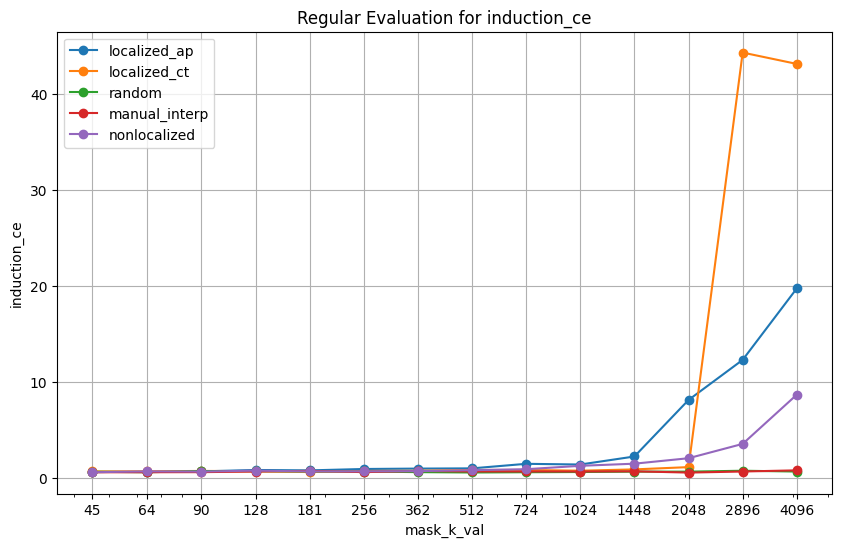

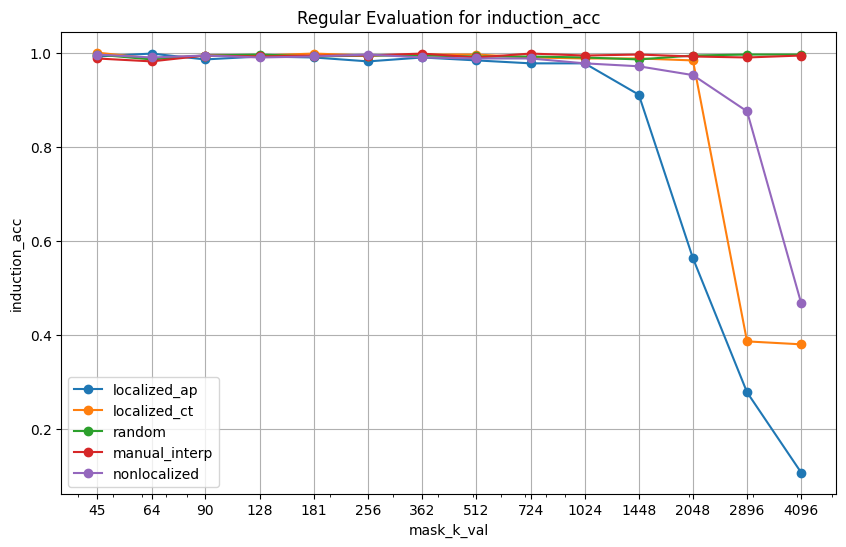

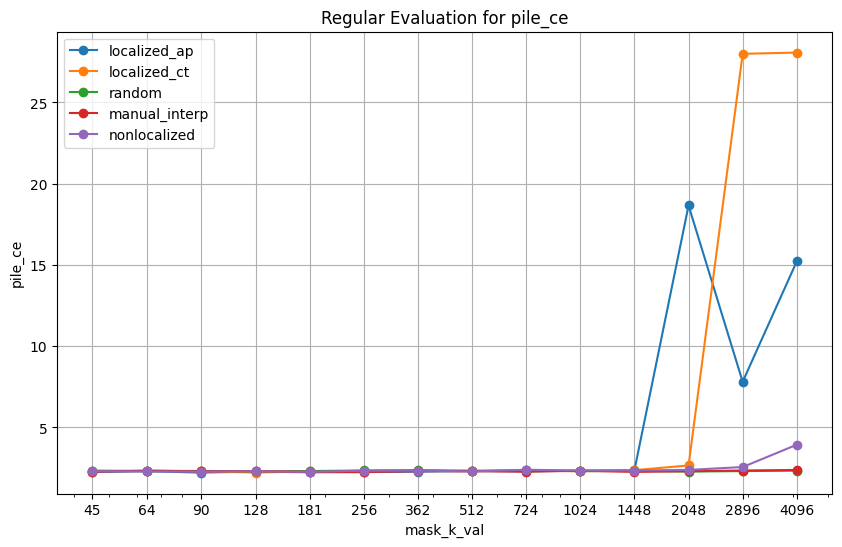

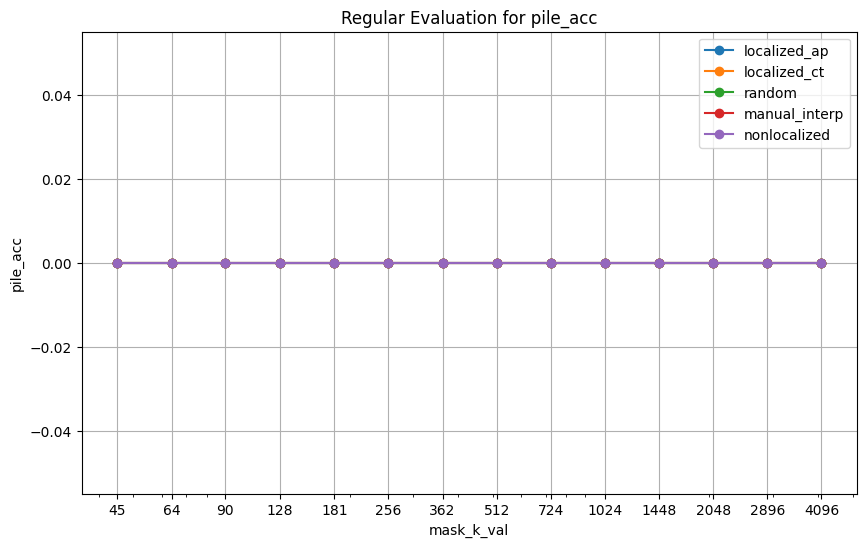

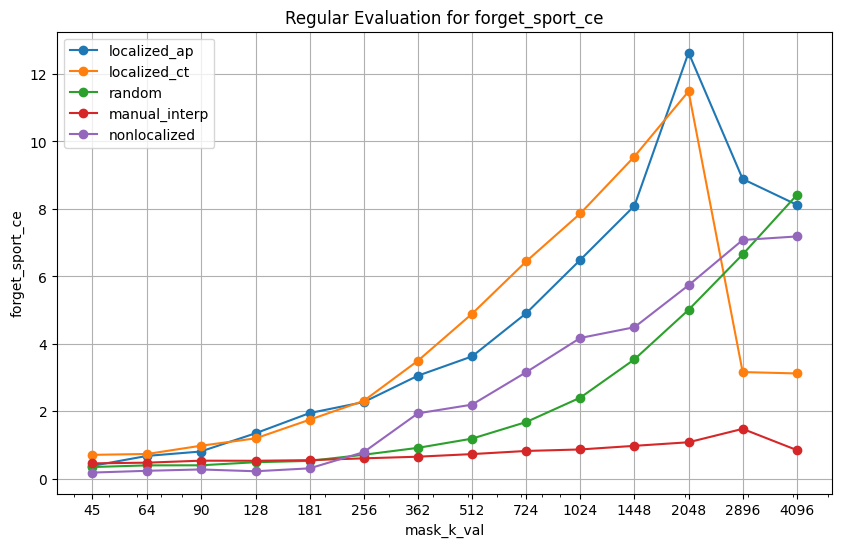

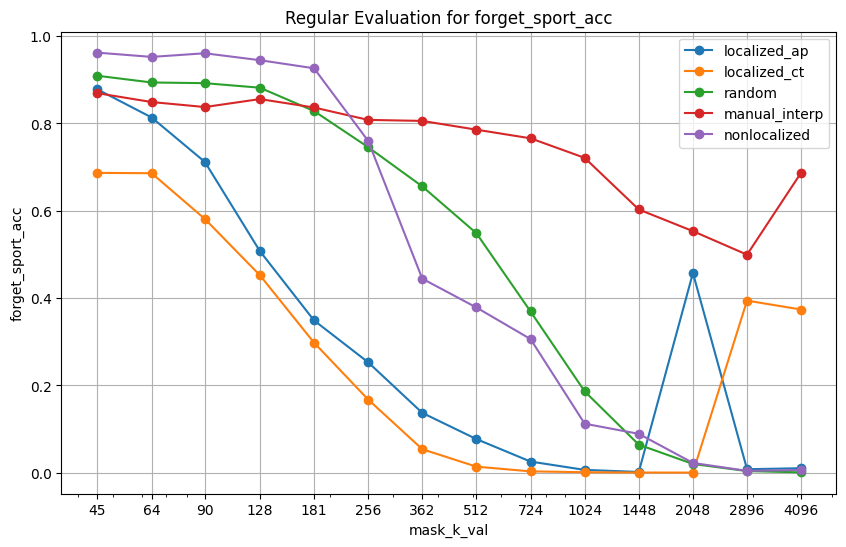

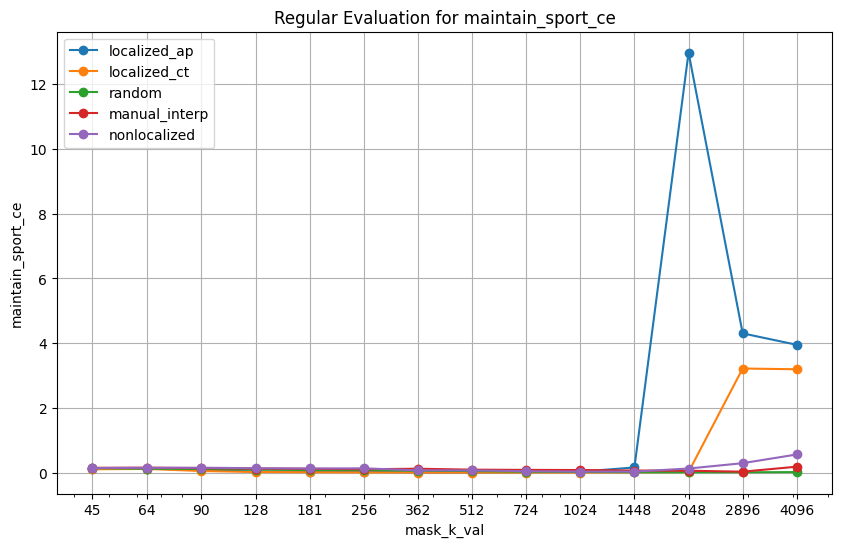

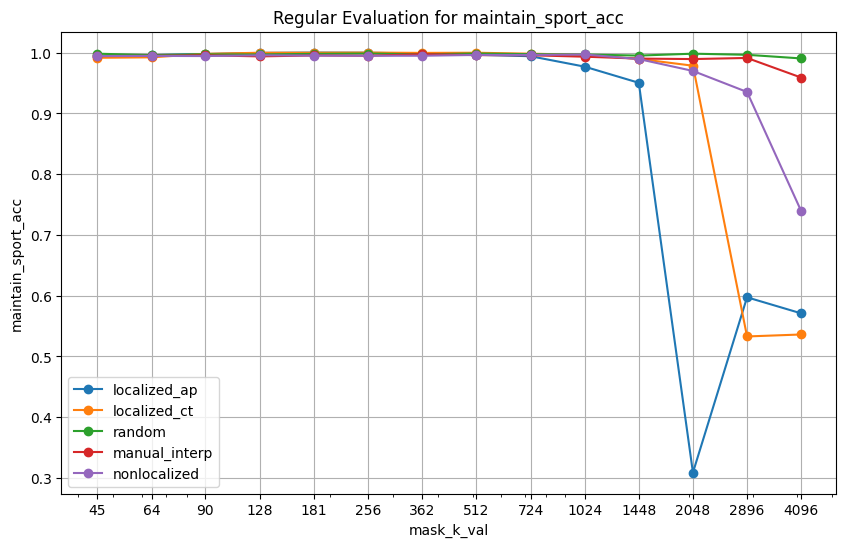

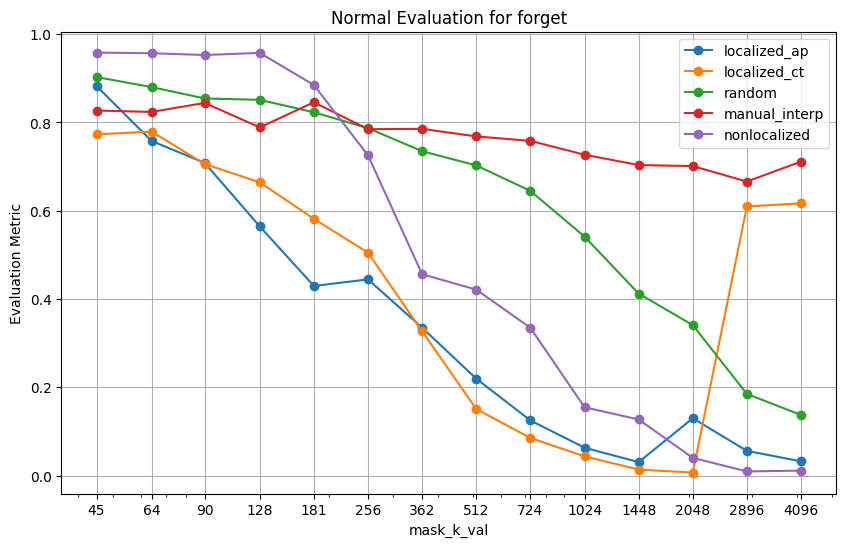

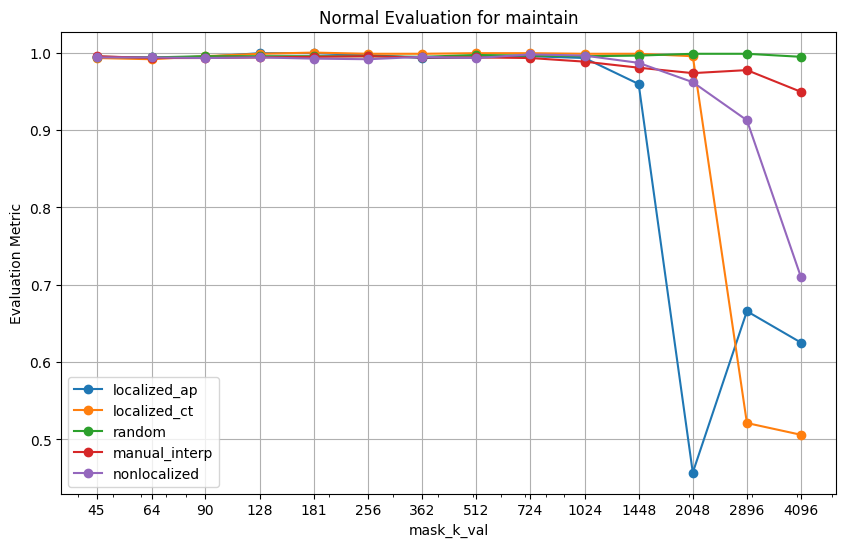

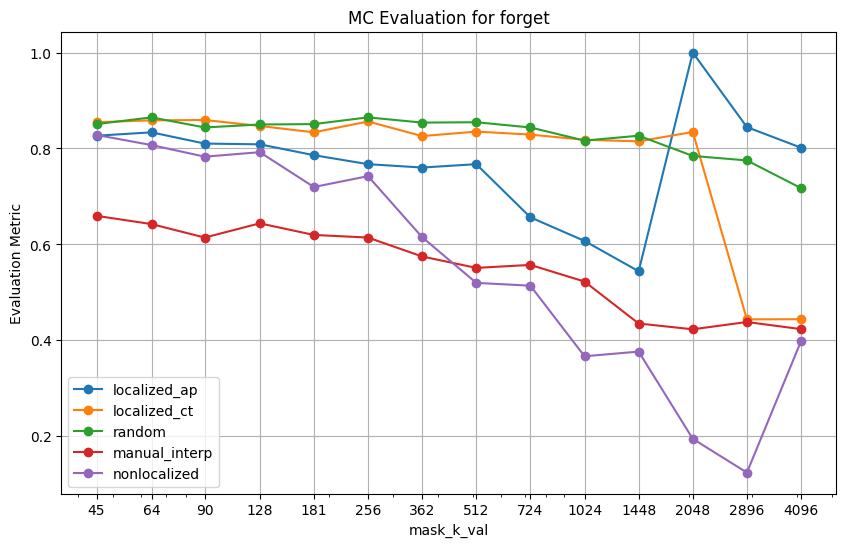

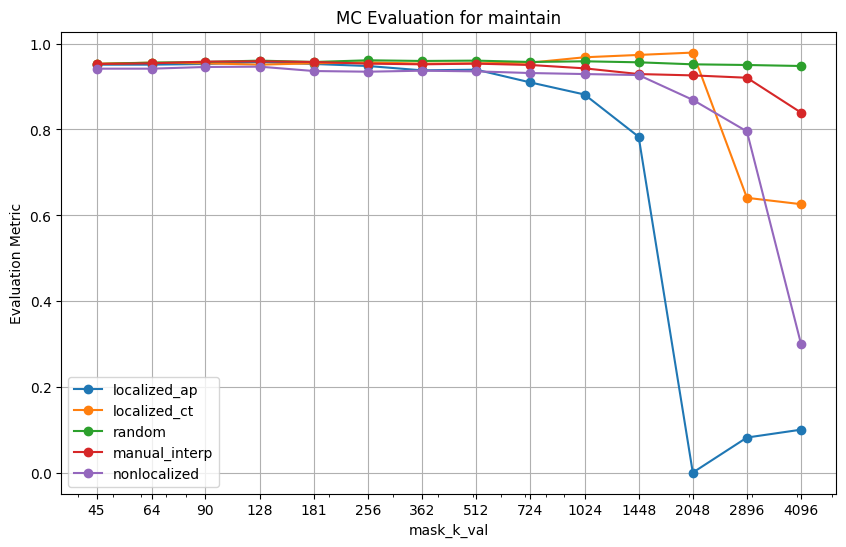

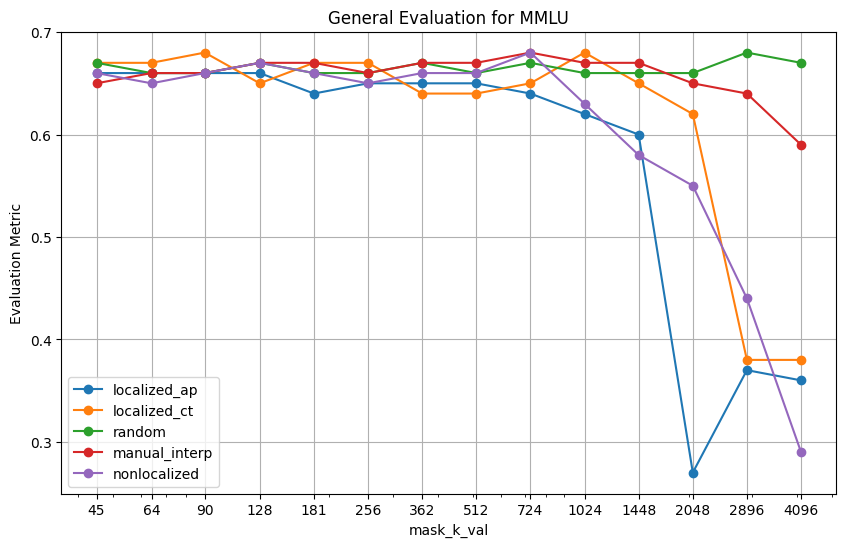

In [14]:
import pickle
beta=3
with open(f"{save_dir}/results/neuron_cb_unlearn_athletes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_pareto_comparisons.pkl", "rb") as f:
    results = pickle.load(f)
    all_regular_evals = results['all_regular_evals']
    all_side_effect_evals = results['all_side_effect_evals']
    all_adversarial_evals = results['all_adversarial_evals']
    # localized_regular_evals = results['localized_regular_evals']
    # localized_side_effect_evals = results['localized_side_effect_evals']
    # localized_adversarial_evals = results['localized_adversarial_evals']
    # nonlocalized_regular_evals = results['nonlocalized_regular_evals']
    # nonlocalized_side_effect_evals = results['nonlocalized_side_effect_evals']
    # nonlocalized_adversarial_evals = results['nonlocalized_adversarial_evals']

import matplotlib.pyplot as plt
import numpy as np

def plot_regular_evaluations(task_regular_evals, task_name, y_label="Evaluation Metric", mask_k_vals=None):
    plt.figure(figsize=(10, 6))

    sample_key = list(task_regular_evals.keys())[0]
    if mask_k_vals is None:
        mask_k_vals = sorted(task_regular_evals[sample_key].keys())

    for localization_type, regular_evals in task_regular_evals.items():
        if mask_k_vals is None:
            mask_k_vals = sorted(regular_evals.keys())
        # mask_k_vals = sorted(regular_evals.keys())
        scores = [regular_evals[k][task_name] for k in mask_k_vals]
        plt.plot(mask_k_vals, scores, label=localization_type, marker='o')

    # mask_k_vals = sorted(all_regular_evals['localized'].keys())

    # mask_k_vals = sorted(localized_evals.keys())
    # localized_scores = [localized_evals[k][task_name] for k in mask_k_vals]
    # nonlocalized_scores = [nonlocalized_evals[k][task_name] for k in mask_k_vals]

    # plt.plot(mask_k_vals, localized_scores, label='Localized', marker='o')
    # plt.plot(mask_k_vals, nonlocalized_scores, label='Nonlocalized', marker='o')
    plt.xlabel('mask_k_val')
    plt.ylabel(y_label)
    plt.title(f'Regular Evaluation for {task_name}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

# def plot_nested_evaluations_with_checks(localized_evals, nonlocalized_evals, eval_type, nested_key):
#     mask_k_vals = sorted(localized_evals.keys())
#     localized_scores = []
#     nonlocalized_scores = []

#     for k in mask_k_vals:
#         # Check and append localized scores
#         if eval_type in localized_evals[k] and nested_key in localized_evals[k][eval_type]:
#             localized_scores.append(localized_evals[k][eval_type][nested_key])
#         else:
#             localized_scores.append(None)  # or use -1 or np.nan

#         # Check and append nonlocalized scores
#         if eval_type in nonlocalized_evals[k] and nested_key in nonlocalized_evals[k][eval_type]:
#             nonlocalized_scores.append(nonlocalized_evals[k][eval_type][nested_key])
#         else:
#             nonlocalized_scores.append(None)  # or use -1 or np.nan

#     plt.figure(figsize=(10, 6))
#     plt.plot(mask_k_vals, localized_scores, label='Localized', marker='o')
#     plt.plot(mask_k_vals, nonlocalized_scores, label='Nonlocalized', marker='o')
#     plt.xlabel('mask_k_val')
#     plt.ylabel('Evaluation Metric')
#     plt.title(f'{eval_type} Evaluation for {nested_key}')
#     plt.legend()
#     plt.grid(True)
#     plt.xscale('log')  # Set x-axis to logarithmic scale
#     plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
#     plt.show()
def plot_nested_evaluations_with_checks(all_evals, eval_type, nested_key, mask_k_vals=None):
    plt.figure(figsize=(10, 6))
    if mask_k_vals is None:
        mask_k_vals = sorted(next(iter(all_evals.values())).keys())  # Assuming all have the same k values

    for localization_type, evals in all_evals.items():
        scores = []
        for k in mask_k_vals:
            if eval_type in evals[k] and nested_key in evals[k][eval_type]:
                scores.append(evals[k][eval_type][nested_key])
            else:
                scores.append(None)  # or use -1 or np.nan
        plt.plot(mask_k_vals, scores, label=localization_type, marker='o')

    plt.xlabel('mask_k_val')
    plt.ylabel('Evaluation Metric')
    plt.title(f'{eval_type} Evaluation for {nested_key}')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xticks(mask_k_vals, labels=mask_k_vals)  # Ensure ticks are set correctly for log scale
    plt.show()

# Plotting regular evaluations
# for task in ['induction', 'pile', 'forget_sport', 'maintain_sport']:

# for task in list(localized_regular_evals.values())[0].keys():
#     plot_regular_evaluations(localized_regular_evals, nonlocalized_regular_evals, task, y_label=task)
mask_k_vals =[int(2**(i/2)) for i in range(11, 25)]
sample_key = list(all_regular_evals.keys())[0]
for task in list(all_regular_evals[sample_key].values())[0].keys():
    plot_regular_evaluations(all_regular_evals, task, y_label=task, mask_k_vals=mask_k_vals)


# Plotting adversarial evaluations
for eval_type in ['Normal', 'MC']:
    for sport in ['forget', 'maintain']:
        plot_nested_evaluations_with_checks(all_adversarial_evals, eval_type, sport, mask_k_vals=mask_k_vals)

# Plotting side effect evaluations with checks for missing keys
# for eval_type in ['Sports Answers', 'Cross Entropy', 'General']:
for eval_type in ['General']:
    if eval_type == 'Sports Answers':
        for sport in ['football', 'baseball', 'basketball', 'tennis']:
            plot_nested_evaluations_with_checks(all_side_effect_evals, eval_type, sport, mask_k_vals=mask_k_vals)
    elif eval_type == 'Cross Entropy':
        for category in ['Pile', 'OWT']:
            plot_nested_evaluations_with_checks(all_side_effect_evals, eval_type, category, mask_k_vals=mask_k_vals)
    elif eval_type == 'General':
        for metric in ['MMLU']:
            plot_nested_evaluations_with_checks(all_side_effect_evals, eval_type, metric, mask_k_vals=mask_k_vals)

# # Plotting adversarial evaluations
# # for eval_type in ['Normal', 'MC', 'Capitalized', 'Dashed']:
# for eval_type in list(localized_adversarial_evals.values())[0].keys():
#     # for sport in ['football', 'baseball', 'basketball']:
#     for sport in list(localized_adversarial_evals.values())[0][eval_type].keys():
#         plot_nested_evaluations_with_checks(localized_adversarial_evals, nonlocalized_adversarial_evals, eval_type, sport)

# # Plotting side effect evaluations with checks for missing keys
# for eval_type in ['Sports Answers', 'Cross Entropy']:
#     if eval_type == 'Sports Answers':
#         for sport in ['football', 'baseball', 'basketball', 'tennis']:
#             plot_nested_evaluations_with_checks(localized_side_effect_evals, nonlocalized_side_effect_evals, eval_type, sport)
#     elif eval_type == 'Cross Entropy':
#         for category in ['Pile', 'OWT']:
#             plot_nested_evaluations_with_checks(localized_side_effect_evals, nonlocalized_side_effect_evals, eval_type, category)


### Scatterplots

In [ ]:
# scatterplot of neuron mask values, x_axis and y_axis are different localizations

def plot_

## Relearning Evals

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
def do_relearning(model, mask, train_tasks, n_iters, finetune_mask=True, finetune_lora=False, lora_kwargs={'rank': 64, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 1e-2, 'weight_decay': 0, 'use_cosine': False}):
    # can either finetune mask or lora
    assert finetune_mask + finetune_lora == 1, "can only finetune one"

    if finetune_mask:
        optimizer = torch.optim.AdamW(mask.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])

    elif finetune_lora:
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=lora_kwargs['rank'],
            lora_alpha=lora_kwargs['alpha'],
            lora_dropout=lora_kwargs['dropout'],
            target_modules = lora_kwargs['target_modules'], #["q_proj", "v_proj", 
        )

        model = get_peft_model(model, peft_config).cuda()
        # model.print_trainable_parameters()

        optimizer = torch.optim.AdamW(model.parameters(), **learning_kwargs)
    
    if learning_kwargs['use_cosine']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_iters)

    for i in range(n_iters):
        optimizer.zero_grad()
        for task, task_weight in train_tasks.values():
            loss = task.get_train_loss(model) * task_weight
            # print(loss.item())
            loss.backward()
        
        optimizer.step()
        if finetune_mask:
            mask.on_step_end()
        if learning_kwargs['use_cosine']:
            scheduler.step()


In [ ]:
n_eval_iters = 15
n_relearn_iters = 20
n_relearn_athletes = 2
mask_k_vals = [10, 20, 40, 80, 160, 200, 320, 480, 640, 960]

if forget_sport is None:
    relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)
else:
    relearn_sport = SportsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_sport_subset={forget_sport}, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)
pile = PileTask(batch_size=8, tokenizer=tokenizer, ctx_length=256, shuffle=True, buffer_size=1000)
train_tasks = {"relearn_athletes": (relearn_sport, .2), "pile": (train_pile, 1)}

from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:
initial_results = {}
relearning_adversarial_results = {}
try:
    del mask
except:
    pass
model.reset_hooks()

for name in mask_init_funcs.keys():

    initial_results[name] = {}
    relearning_adversarial_results[name] = {}

    for k in tqdm(mask_k_vals):
        mask = mask_init_funcs[name](model)
        mask.cuda()

        mask.undiscretize()
        mask.discretize_topk(k)
        mask.merge_discretizations()

        # do relearning
        # initial_results[name][k] = {}
        # initial_results[name][k]['relearn_sport'] = relearn_sport.get_test_loss(model)
        # initial_results[name][k]['pile'] = pile.get_test_loss(model)
        # print(f"Before relearning {name} and {k=}, relearn loss = {initial_results[name][k]['relearn_sport']=}, pile loss = {initial_results[name][k]['pile']}")
        do_relearning(model, mask, train_tasks, n_iters=n_relearn_iters, finetune_mask=True, finetune_lora=False, learning_kwargs={'lr': 1e-2, 'weight_decay': 0, 'use_cosine': True})


        adversarial_eval_results = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
        relearning_adversarial_results[name][k] = adversarial_eval_results

        mask.cpu()
        model.reset_hooks()
        del mask
